In [1]:
import tensorflow as tf
import tensorlayer as tl
import numpy as np

In [2]:
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt  # dealing with plots 

In [3]:
# Helper function to load images information (image_path, image_label)
def load_image_path(data_path, valid_proportion, test_proportion):
    pos_image_path = []
    pos_labels = []

    neg_image_path = []
    neg_labels = []

    ful_image_path = []
    ful_labels = []

    np.random.seed(0)

    pos_path = data_path + "1/"
    for img in tf.gfile.ListDirectory(pos_path):
        # if '.bmp' not in img:
        #    continue

        label = 1

        path = os.path.join(pos_path, img)
        pos_image_path.append(path)
        pos_labels.append(label)

    neg_path = data_path + "0/"
    for img in tf.gfile.ListDirectory(neg_path):
        # if '.bmp' not in img:
        #    continue

        label = 0

        path = os.path.join(neg_path, img)
        neg_image_path.append(path)
        neg_labels.append(label)

    ful_image_path = pos_image_path + neg_image_path
    ful_labels = pos_labels + neg_labels

    temp = np.array([ful_image_path, ful_labels])
    temp = temp.transpose()
    np.random.shuffle(temp)
    ful_image_path = list(temp[:, 0])
    ful_labels = list(temp[:, 1])
    ful_labels = [int(i) for i in ful_labels]

    x_train, x_valid, y_train, y_valid = train_test_split(ful_image_path, ful_labels,
                                                          test_size=(valid_proportion + test_proportion),
                                                          stratify=ful_labels, random_state=1)
    x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=test_proportion / (
            valid_proportion + test_proportion), stratify=y_valid, random_state=1)

    print("train_num: %d ,pos_num: %d , neg_num: %d" % (
        len(y_train), count_pos(y_train), len(y_train) - count_pos(y_train)))
    print("valid_num: %d ,pos_num: %d , neg_num: %d" % (
        len(y_valid), count_pos(y_valid), len(y_valid) - count_pos(y_valid)))
    print("test_num : %d ,pos_num: %d , neg_num: %d" % (
        len(y_test), count_pos(y_test), len(y_test) - count_pos(y_test)))

    return x_train, y_train, x_valid, y_valid, x_test, y_test


def get_batch(x, y, image_W, image_H, batch_size, capacity=500, epochs = None):
    '''
    Args:
        x: list type
        y: list type
        image_W: image width
        image_H: image height
        batch_size: batch size
        capacity: the maximum elements in queue
        epochs: 如果要指定epoch数
    Returns:
        image_batch: 4D tensor [batch_size, width, height, 3], dtype=tf.float32
        label_batch: 1D tensor [batch_size], dtype=tf.int32
    '''

    x = tf.cast(x, tf.string)
    y = tf.cast(y, tf.int32)

    # make an input queue
    input_queue = tf.train.slice_input_producer([x, y],num_epochs=epochs)

    label = input_queue[1]
    image_contents = tf.read_file(input_queue[0])
    image = tf.image.decode_jpeg(image_contents, channels=3)

    ######################################
    # data argumentation should go to here
    ######################################

    image = tf.image.resize_images(image, [image_W, image_H], method=0)
    # image = tf.image.resize_image_with_crop_or_pad(image, image_W, image_H)
    # if you want to test the generated batches of images, you might want to comment the following line.
    # 如果想看到正常的图片，请注释掉111行（标准化）和 126行（image_batch = tf.cast(image_batch, tf.float32)）
    # 训练时不要注释掉！
    image = tf.image.per_image_standardization(image)

    image_batch, label_batch = tf.train.batch([image, label],
                                              batch_size=batch_size,
                                              num_threads=64,
                                              capacity=capacity)

    image_batch = tf.cast(image_batch, tf.float32)
    label_batch = tf.reshape(label_batch, [batch_size])

    # label_batch = to_categorical(y=label_batch, nb_classes=2)
    return image_batch, label_batch


def count_pos(lables):
    num = 0
    for i in range(len(lables)):
        if lables[i] == 1:
            num = num + 1
    return num

In [4]:
Train_Proportion = 0.8  # Proportion of the data to be used for training
Valid_Proportion = 0.1
Test_Proportion = 0.1  #
data_dir = "F:/Github/clone/image_food_classification/datasets/food_101_dataset/"

In [5]:
x_train, y_train, x_valid, y_valid, x_test, y_test = load_image_path(data_dir, Valid_Proportion,Test_Proportion)

train_num: 3593 ,pos_num: 757 , neg_num: 2836
valid_num: 449 ,pos_num: 95 , neg_num: 354
test_num : 450 ,pos_num: 95 , neg_num: 355


In [6]:
IMG_W = 208  # resize the image, if the input image is too large, training will be very slow.
IMG_H = 208
batch_size = 64

In [7]:
def predict(X, x, sess, network):
    """
    对单一图片进行测试结果
    
    Args:
        X : 3D的tensor,一般是[IMG_H, IMG_W, 3]
            The inputs.
        x : placeholder，4D，一般是[?,IMG_W,IMG_H,3]
            For inputs.
        sess : Session
            TensorFlow Session.
        network : TensorLayer layer
            The network.
    
    Returns:
        numpy.ndarray
    """

    feed_dict = {x: sess.run(X).reshape([1,IMG_W,IMG_H,3])}#feed_dict不支持tensor,然后就是要保证是4D的tensor
    
    logist = network.outputs
    y_ = tf.argmax(tf.nn.softmax(logist), 1)
    return sess.run(y_, feed_dict=feed_dict)

In [8]:
def evaluation(x_test,y_test,x, sess, network):
    """
    在数据集上进行结果验证，打印出精度和分错的图片的index
    
    Args:
        x_test : list, dtype:str
            图片所在路径
        y_test ：list, dtype:str
            标签
        x : placeholder，4D，一般是[?,IMG_W,IMG_H,3]
            For inputs.
        sess : Session
            TensorFlow Session.
        network : TensorLayer layer
            The network.
            
    """
    y_predict = []
    err_index = []
    for index,path in enumerate(x_test):
        
        file_content = tf.gfile.FastGFile(path, 'rb').read() # 一定记得使用rb读取, 不然很多情况下都会报错
        image = tf.image.decode_jpeg(file_content, channels=3) # 本教程以JPG图片为例
        
        image = tf.image.resize_images(image, [IMG_W, IMG_H], method=0)
        image = tf.image.per_image_standardization(image)
        
        y_ = list(predict(image, x, sess, network))
        y_predict += y_
        
        if not y_predict[index] == y_test[index]:
            err_index.append(index)
        
    from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
#     c_mat = confusion_matrix(y_test, y_predict, labels=[x for x in range(n_classes)])
#     f1 = f1_score(y_test, y_predict, average=None, labels=[x for x in range(n_classes)])
#     f1_macro = f1_score(y_test, y_predict, average='macro')
    acc = accuracy_score(y_test, y_predict)
    
    print("accuracy : " + str(acc))
    print("err_index : " + str(err_index))

In [9]:
x = tf.placeholder(tf.float32, shape=[None, IMG_H, IMG_W, 3], name='x')

network = tl.layers.InputLayer(x, name='input')
network = tl.layers.Conv2dLayer(network,
                               act=tf.nn.relu,
                               shape=[5, 5, 3, 32],  # 32 features for each 5x5 patch
                               strides=[1, 1, 1, 1],
                               padding='SAME',
                               name='cnn_layer1')  # output: (?, 208, 208, 32)
network = tl.layers.PoolLayer(network,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             pool=tf.nn.max_pool,
                             name='pool_layer1', )  # output: (?, 104, 104, 32)
network = tl.layers.Conv2dLayer(network,
                               act=tf.nn.relu,
                               shape=[5, 5, 32, 64],  # 64 features for each 5x5 patch
                               strides=[1, 1, 1, 1],
                               padding='SAME',
                               name='cnn_layer2')  # output: (?, 104, 104, 64)
network = tl.layers.PoolLayer(network,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             pool=tf.nn.max_pool,
                             name='pool_layer2', )  # output: (?, 52, 52, 64)
network = tl.layers.Conv2dLayer(network,
                               act=tf.nn.relu,
                               shape=[5, 5, 64, 128],  # 32 features for each 5x5 patch
                               strides=[1, 1, 1, 1],
                               padding='SAME',
                               name='cnn_layer3')  # output: (?, 52, 52, 128)
network = tl.layers.PoolLayer(network,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             pool=tf.nn.max_pool,
                             name='pool_layer3', )  # output: (?, 26, 26, 128)
network = tl.layers.Conv2dLayer(network,
                               act=tf.nn.relu,
                               shape=[5, 5, 128, 256],  # 64 features for each 5x5 patch
                               strides=[1, 1, 1, 1],
                               padding='SAME',
                               name='cnn_layer4')  # output: (?, 26, 26, 256)
network = tl.layers.PoolLayer(network,
                             ksize=[1, 2, 2, 1],
                             strides=[1, 2, 2, 1],
                             padding='SAME',
                             pool=tf.nn.max_pool,
                             name='pool_layer4', )  # output: (?, 13, 13, 256)

network = tl.layers.FlattenLayer(network, name='flatten_layer')
# output: (?, 3136)
network = tl.layers.DropoutLayer(network, keep=0.5, is_fix=True, name='drop1',is_train=False)
# output: (?, 3136)
network = tl.layers.DenseLayer(network, n_units=256, act=tf.nn.relu, name='relu1')
# output: (?, 256)
network = tl.layers.DropoutLayer(network, keep=0.5, is_fix=True, name='drop2',is_train=False)
# output: (?, 256)
network = tl.layers.DenseLayer(network, n_units=2,
                              act=tf.identity, name='output_layer')

  [TL] InputLayer  input: (?, 208, 208, 3)
  [TL] Conv2dLayer cnn_layer1: shape:[5, 5, 3, 32] strides:[1, 1, 1, 1] pad:SAME act:relu
  [TL] PoolLayer   pool_layer1: ksize:[1, 2, 2, 1] strides:[1, 2, 2, 1] padding:SAME pool:max_pool
  [TL] Conv2dLayer cnn_layer2: shape:[5, 5, 32, 64] strides:[1, 1, 1, 1] pad:SAME act:relu
  [TL] PoolLayer   pool_layer2: ksize:[1, 2, 2, 1] strides:[1, 2, 2, 1] padding:SAME pool:max_pool
  [TL] Conv2dLayer cnn_layer3: shape:[5, 5, 64, 128] strides:[1, 1, 1, 1] pad:SAME act:relu
  [TL] PoolLayer   pool_layer3: ksize:[1, 2, 2, 1] strides:[1, 2, 2, 1] padding:SAME pool:max_pool
  [TL] Conv2dLayer cnn_layer4: shape:[5, 5, 128, 256] strides:[1, 1, 1, 1] pad:SAME act:relu
  [TL] PoolLayer   pool_layer4: ksize:[1, 2, 2, 1] strides:[1, 2, 2, 1] padding:SAME pool:max_pool
  [TL] FlattenLayer flatten_layer: 43264
  [TL] skip DropoutLayer
  [TL] DenseLayer  relu1: 256 relu
  [TL] skip DropoutLayer
  [TL] DenseLayer  output_layer: 2 identity


In [11]:
#读取ckpt里保存的参数
sess = tf.InteractiveSession()
saver = tf.train.Saver(max_to_keep=2)
checkpoint_dir = "C:/Users/hsqyc/Desktop/3/"
if tf.train.get_checkpoint_state(checkpoint_dir): #确认是否存在
    saver.restore(sess,checkpoint_dir + "Foodfood_model.ckpt-250")
    print("load ok!")
else:
    print("ckpt文件不存在")

INFO:tensorflow:Restoring parameters from C:/Users/hsqyc/Desktop/3/Foodfood_model.ckpt-250
load ok!


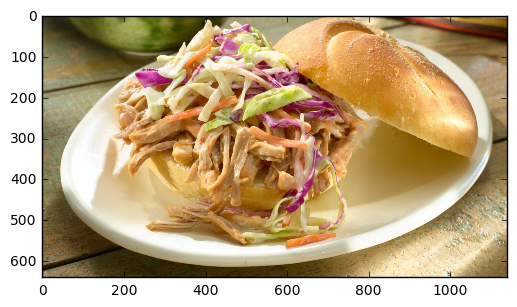

y : 0
y_ : [0]


In [12]:
#单张图片进行predict
index = 3
path = x_test[index]
file_content = tf.gfile.FastGFile(path, 'rb').read() # 一定记得使用rb读取, 不然很多情况下都会报错
image = tf.image.decode_jpeg(file_content, channels=3) # 本教程以JPG图片为例

with tf.Session() as sess1:
    
    A = sess1.run(image)
    plt.imshow(A)
    plt.show()

image = tf.image.resize_images(image, [IMG_W, IMG_H], method=0)
image = tf.image.per_image_standardization(image)

print("y : " + str(y_test[index]))
y_ = predict(image, x, sess, network)
print("y_ : " + str(y_))

In [79]:
evaluation(x_test[],y_test[],x, sess, network)

accuracy : 0.897777777778
err_index : [13, 15, 29, 34, 35, 47, 58, 71, 73, 95, 112, 114, 116, 133, 149, 154, 159, 164, 178, 180, 188, 201, 205, 240, 242, 266, 267, 268, 274, 276, 297, 302, 304, 310, 317, 323, 325, 326, 331, 350, 356, 362, 397, 401, 426, 448]


In [ ]:
sess.close()